### Preparing Dataset

In [ ]:
import zipfile
import os

# Path to your dataset zip
zip_path = "/content/drive/MyDrive/inaturalist_12K.zip"
extract_path = "/content/inaturalist_12K"

# Unzip only if not already done
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
from sklearn.model_selection import StratifiedShuffleSplit

# PyTorch Lightning DataModule for handling train/val/test splits and dataloaders
class InatDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, num_workers=4):
        """
        Initialize the data module with root data directory, batch size, and number of workers.
        """
        super().__init__()
        self.data_dir = data_dir              # Root directory containing 'train' and 'val' folders
        self.batch_size = batch_size          # Batch size for dataloaders
        self.num_workers = num_workers        # Number of workers for parallel data loading

    def setup(self, stage=None):
        """
        Prepare datasets for training, validation, and testing.
        This is called automatically by PyTorch Lightning at the right time.
        """
        # Define image transformations: resize, convert to tensor, and normalize with ImageNet stats
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images to 224x224
            transforms.ToTensor(),          # Convert PIL image to tensor
            transforms.Normalize(           # Normalize using ImageNet mean and std
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Load full dataset from the 'train' directory with the defined transform
        full_dataset = ImageFolder(os.path.join(self.data_dir, 'train'), transform=transform)

        # Get class labels for stratified split
        targets = full_dataset.targets

        # Perform stratified split to maintain class balance in train and validation sets
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
        train_idx, val_idx = next(sss.split(range(len(full_dataset)), targets))

        # Create train and validation subsets using the indices from stratified split
        self.train_dataset = Subset(full_dataset, train_idx)
        self.val_dataset = Subset(full_dataset, val_idx)

        # Load test dataset from the 'val' directory (often used for test set in image challenges)
        self.test_dataset = ImageFolder(os.path.join(self.data_dir, 'val'), transform=transform)

    def train_dataloader(self):
        """
        Return DataLoader for training set with shuffling.
        """
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        """
        Return DataLoader for validation set without shuffling.
        """
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        """
        Return DataLoader for test set without shuffling.
        """
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

In [ ]:
import torch.nn as nn
import torchvision
from torchmetrics.classification import Accuracy, ConfusionMatrix
import pytorch_lightning as pl
import torch

# PyTorch Lightning Module for fine-tuning GoogLeNet on a custom classification task
class GoogLeNetFineTune(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        """
        Initializes the GoogLeNet model for fine-tuning.
        Args:
            num_classes: Number of output classes for classification.
            lr: Learning rate for optimizer.
        """
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters for logging/checkpointing

        # Load the pretrained GoogLeNet model from torchvision
        self.model = torchvision.models.googlenet(pretrained=True)

        # === FREEZING ===
        # Freeze all layers so they are not updated during backpropagation
        for param in self.model.parameters():
            param.requires_grad = False

        # === REPLACING CLASSIFIER ===
        # Get number of features in the last fully connected (fc) layer
        in_features = self.model.fc.in_features

        # Replace the original fc layer with a new one suited for our num_classes
        self.model.fc = nn.Linear(in_features, num_classes)

        # Unfreeze the new fc layer so it can be trained
        for param in self.model.fc.parameters():
            param.requires_grad = True

        # Define loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Define metrics for train, val, and test
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        """
        Forward pass: input image → model → logits.
        """
        return self.model(x)

    def configure_optimizers(self):
        """
        Define the optimizer. Only optimize the classifier (fc layer) since others are frozen.
        """
        return torch.optim.Adam(self.model.fc.parameters(), lr=self.hparams.lr)

    def training_step(self, batch, batch_idx):
        """
        Training step: compute loss and accuracy, log them.
        """
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.train_acc(logits.softmax(dim=-1), y)

        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step: compute loss and accuracy, log them.
        """
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.val_acc(logits.softmax(dim=-1), y)

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        """
        Test step: compute accuracy and update confusion matrix.
        """
        x, y = batch
        logits = self(x)
        acc = self.test_acc(logits.softmax(dim=-1), y)

        self.test_confmat.update(logits.softmax(dim=-1), y)

        self.log("test_acc", acc, on_step=False, on_epoch=True)

    def on_test_epoch_end(self):
        """
        At the end of the test epoch, compute and store confusion matrix.
        """
        confmat = self.test_confmat.compute().cpu().numpy()
        self.test_confmat.reset()
        self.confmat_result = confmat  # Store for plotting or further analysis


### **Freezing Explained**

In PyTorch, every parameter in a model has a `requires_grad` attribute:

```python
for param in self.model.parameters():
    param.requires_grad = False
```

- This **freezes all layers**, preventing their weights from being updated during training.
- It's useful when you want to **retain pretrained features** and only train the final layer(s).

Then we **replace the final fully connected (fc) layer**:

```python
self.model.fc = nn.Linear(in_features, num_classes)
```

- This new layer is **not frozen** initially, but just to be explicit, we ensure:

```python
for param in self.model.fc.parameters():
    param.requires_grad = True
```

- So now, only this new classifier head will be updated (fine-tuned) during training, while all other layers stay fixed.

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer

data_dir = "/content/inaturalist_12K"
dm = InatDataModule(data_dir=data_dir, batch_size=32)
model = GoogLeNetFineTune(num_classes=10, lr=1e-3)

callbacks = [
    EarlyStopping(monitor="val_loss", mode="min", patience=3),
    ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1),
]
logger = CSVLogger("logs", name="googlenet_inat")

trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    precision=16,
    logger=logger,
    callbacks=callbacks
)

# Training
trainer.fit(model, datamodule=dm)

# Testing on the official val folder (test set)
trainer.test(model, datamodule=dm)


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                      | Params | Mode 
-------------------------------------------------------------------
0 | model        | GoogLeNet                 | 5.6 M  | train
1 | loss_fn      | CrossEntropyLoss          | 0      | train
2 | train_acc    | MulticlassAccuracy        | 0      | train
3 | val_acc      | MulticlassAccuracy        | 0      | train
4 | test_acc     | MulticlassAccuracy        | 0      | train
5 | test_confmat | MulticlassConfusionMatrix | 0      | train
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7170000076293945     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7170000076293945}]

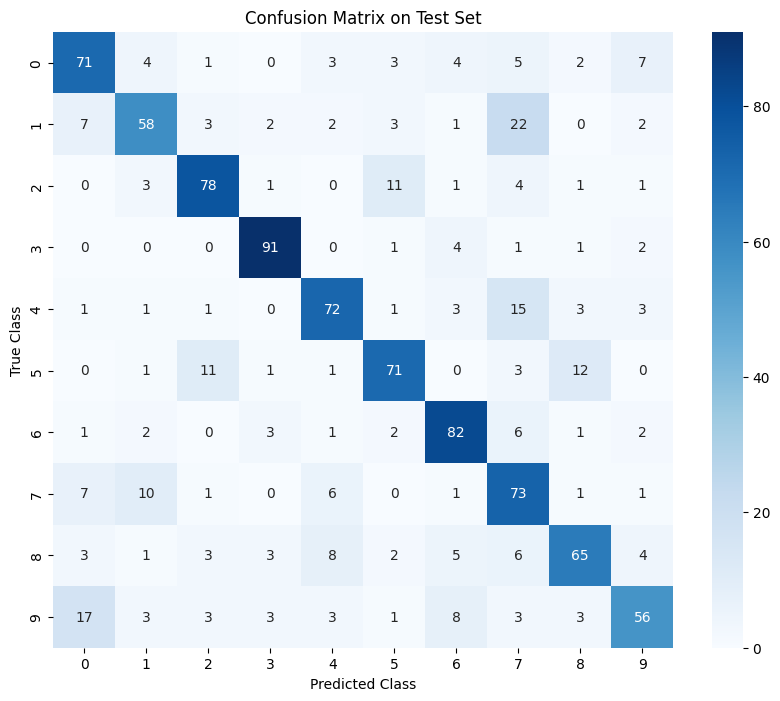

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Retrieve stored confusion matrix
confmat = model.confmat_result

plt.figure(figsize=(10, 8))
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
